# Challenge 12: Deep Learning Image Classification with CIFAR-10

## Overview

This challenge implements and compares multiple deep learning architectures for image classification on the CIFAR-10 dataset. We build and evaluate:
- Simple CNN
- LeNet
- VGG-style architecture
- ResNet-style architecture
- Transfer learning with pre-trained ResNet18
- Transfer learning with pre-trained VGG16

Each model is trained, evaluated, and compared based on accuracy, training time, and model complexity.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Task 1: Dataset Selection and Data Preprocessing

We use the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 classes. Data preprocessing includes normalization and augmentation techniques.

In [2]:
# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Simple normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')
print(f'Classes: {classes}')

100%|██████████| 170M/170M [00:08<00:00, 21.0MB/s] 


Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Visualize Sample Images

We display a few sample images from the dataset to understand what we're working with.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7305385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8671105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.701273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7402936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7

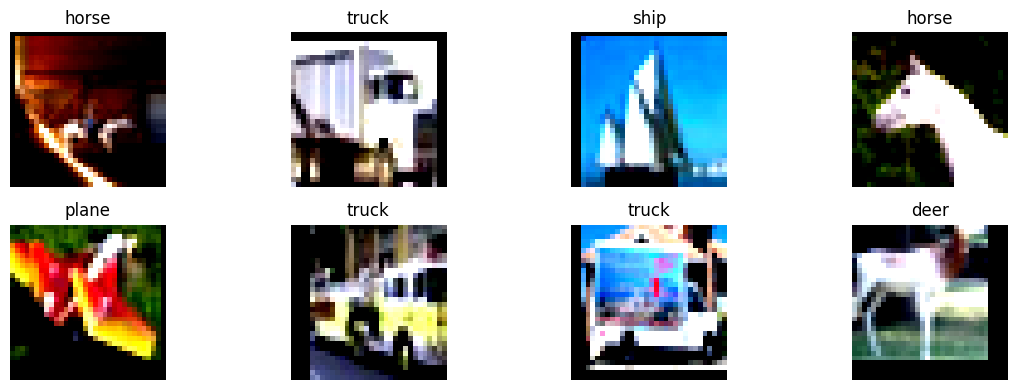

In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()

## Task 2: Model Architectures

We define multiple CNN architectures from simple to complex, including transfer learning models.

### Simple CNN

A basic convolutional neural network with two convolutional layers.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

simple_cnn = SimpleCNN().to(device)
print(f"Simple CNN parameters: {sum(p.numel() for p in simple_cnn.parameters()):,}")

Simple CNN parameters: 2,122,186


### LeNet

LeNet-5 architecture adapted for CIFAR-10 with RGB images.

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet().to(device)
print(f"LeNet parameters: {sum(p.numel() for p in lenet.parameters()):,}")

LeNet parameters: 62,006


### VGG-Style Architecture

A simplified VGG-like architecture with multiple convolutional blocks.

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

vgg = VGG().to(device)
print(f"VGG parameters: {sum(p.numel() for p in vgg.parameters()):,}")

VGG parameters: 3,248,202


### ResNet-Style Architecture

A ResNet-inspired architecture with residual connections for better gradient flow.

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

custom_resnet = CustomResNet().to(device)
print(f"Custom ResNet parameters: {sum(p.numel() for p in custom_resnet.parameters()):,}")

Custom ResNet parameters: 2,779,914


## Task 3: Transfer Learning Models

We use pre-trained models from ImageNet and fine-tune them for CIFAR-10.

### Pre-trained ResNet18

In [8]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)
print(f"ResNet18 parameters: {sum(p.numel() for p in resnet18.parameters()):,}")

ResNet18 parameters: 11,181,642


### Pre-trained VGG16

In [9]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)
print(f"VGG16 parameters: {sum(p.numel() for p in vgg16.parameters()):,}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/pcar/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 73.3MB/s] 


VGG16 parameters: 134,301,514


## Task 4: Model Training with Hyperparameter Tuning

We define training and evaluation functions with progress tracking using tqdm.

In [10]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.001, model_name='Model'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    train_losses = []
    train_accs = []
    test_accs = []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'{model_name} Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/len(train_loader):.3f}', 
                            'acc': f'{100.*correct/total:.2f}%'})
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader)
        test_accs.append(test_acc)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    training_time = time.time() - start_time
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'training_time': training_time,
        'final_test_acc': test_accs[-1]
    }

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

## Task 5: Training All Models

We train each model with optimized hyperparameters and track their performance.

In [11]:
results = {}

# Train Simple CNN
print("\n" + "="*50)
print("Training Simple CNN")
print("="*50)
simple_cnn = SimpleCNN().to(device)
results['Simple CNN'] = train_model(simple_cnn, train_loader, test_loader, 
                                     epochs=15, lr=0.001, model_name='Simple CNN')

# Train LeNet
print("\n" + "="*50)
print("Training LeNet")
print("="*50)
lenet = LeNet().to(device)
results['LeNet'] = train_model(lenet, train_loader, test_loader, 
                               epochs=15, lr=0.001, model_name='LeNet')

# Train VGG
print("\n" + "="*50)
print("Training VGG")
print("="*50)
vgg = VGG().to(device)
results['VGG'] = train_model(vgg, train_loader, test_loader, 
                             epochs=15, lr=0.0001, model_name='VGG')

# Train Custom ResNet
print("\n" + "="*50)
print("Training Custom ResNet")
print("="*50)
custom_resnet = CustomResNet().to(device)
results['Custom ResNet'] = train_model(custom_resnet, train_loader, test_loader, 
                                       epochs=15, lr=0.001, model_name='Custom ResNet')

# Train ResNet18 (Transfer Learning)
print("\n" + "="*50)
print("Training ResNet18 (Transfer)")
print("="*50)
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)
results['ResNet18 (Transfer)'] = train_model(resnet18, train_loader, test_loader, 
                                             epochs=10, lr=0.0001, model_name='ResNet18')

# Train VGG16 (Transfer Learning)
print("\n" + "="*50)
print("Training VGG16 (Transfer)")
print("="*50)
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)
results['VGG16 (Transfer)'] = train_model(vgg16, train_loader, test_loader, 
                                         epochs=10, lr=0.00001, model_name='VGG16')


Training Simple CNN


Simple CNN Epoch 1/15: 100%|██████████| 391/391 [00:08<00:00, 46.54it/s, loss=1.620, acc=40.65%]


Epoch 1: Train Loss: 1.620, Train Acc: 40.65%, Test Acc: 54.90%


Simple CNN Epoch 2/15: 100%|██████████| 391/391 [00:07<00:00, 50.96it/s, loss=1.307, acc=52.91%]


Epoch 2: Train Loss: 1.307, Train Acc: 52.91%, Test Acc: 62.34%


Simple CNN Epoch 3/15: 100%|██████████| 391/391 [00:07<00:00, 51.02it/s, loss=1.167, acc=58.29%]


Epoch 3: Train Loss: 1.167, Train Acc: 58.29%, Test Acc: 66.37%


Simple CNN Epoch 4/15: 100%|██████████| 391/391 [00:07<00:00, 49.83it/s, loss=1.088, acc=61.40%]


Epoch 4: Train Loss: 1.088, Train Acc: 61.40%, Test Acc: 67.47%


Simple CNN Epoch 5/15: 100%|██████████| 391/391 [00:07<00:00, 49.57it/s, loss=1.039, acc=63.39%]


Epoch 5: Train Loss: 1.039, Train Acc: 63.39%, Test Acc: 70.90%


Simple CNN Epoch 6/15: 100%|██████████| 391/391 [00:07<00:00, 49.52it/s, loss=0.997, acc=64.82%]


Epoch 6: Train Loss: 0.997, Train Acc: 64.82%, Test Acc: 70.78%


Simple CNN Epoch 7/15: 100%|██████████| 391/391 [00:07<00:00, 49.95it/s, loss=0.967, acc=65.98%]


Epoch 7: Train Loss: 0.967, Train Acc: 65.98%, Test Acc: 71.75%


Simple CNN Epoch 8/15: 100%|██████████| 391/391 [00:08<00:00, 48.37it/s, loss=0.893, acc=68.42%]


Epoch 8: Train Loss: 0.893, Train Acc: 68.42%, Test Acc: 73.56%


Simple CNN Epoch 9/15: 100%|██████████| 391/391 [00:07<00:00, 50.74it/s, loss=0.870, acc=69.33%]


Epoch 9: Train Loss: 0.870, Train Acc: 69.33%, Test Acc: 73.54%


Simple CNN Epoch 10/15: 100%|██████████| 391/391 [00:07<00:00, 50.19it/s, loss=0.863, acc=69.73%]


Epoch 10: Train Loss: 0.863, Train Acc: 69.73%, Test Acc: 73.95%


Simple CNN Epoch 11/15: 100%|██████████| 391/391 [00:07<00:00, 49.45it/s, loss=0.857, acc=70.17%]


Epoch 11: Train Loss: 0.857, Train Acc: 70.17%, Test Acc: 74.24%


Simple CNN Epoch 12/15: 100%|██████████| 391/391 [00:07<00:00, 49.96it/s, loss=0.849, acc=70.07%]


Epoch 12: Train Loss: 0.849, Train Acc: 70.07%, Test Acc: 74.34%


Simple CNN Epoch 13/15: 100%|██████████| 391/391 [00:07<00:00, 50.56it/s, loss=0.848, acc=70.29%]


Epoch 13: Train Loss: 0.848, Train Acc: 70.29%, Test Acc: 74.61%


Simple CNN Epoch 14/15: 100%|██████████| 391/391 [00:07<00:00, 50.36it/s, loss=0.842, acc=70.55%]


Epoch 14: Train Loss: 0.842, Train Acc: 70.55%, Test Acc: 74.70%


Simple CNN Epoch 15/15: 100%|██████████| 391/391 [00:07<00:00, 50.49it/s, loss=0.826, acc=71.04%]


Epoch 15: Train Loss: 0.826, Train Acc: 71.04%, Test Acc: 74.70%

Training LeNet


LeNet Epoch 1/15: 100%|██████████| 391/391 [00:07<00:00, 51.50it/s, loss=1.778, acc=34.17%]


Epoch 1: Train Loss: 1.778, Train Acc: 34.17%, Test Acc: 46.17%


LeNet Epoch 2/15: 100%|██████████| 391/391 [00:07<00:00, 50.39it/s, loss=1.534, acc=44.14%]


Epoch 2: Train Loss: 1.534, Train Acc: 44.14%, Test Acc: 51.51%


LeNet Epoch 3/15: 100%|██████████| 391/391 [00:07<00:00, 50.78it/s, loss=1.427, acc=48.22%]


Epoch 3: Train Loss: 1.427, Train Acc: 48.22%, Test Acc: 53.40%


LeNet Epoch 4/15: 100%|██████████| 391/391 [00:07<00:00, 50.64it/s, loss=1.363, acc=50.91%]


Epoch 4: Train Loss: 1.363, Train Acc: 50.91%, Test Acc: 55.60%


LeNet Epoch 5/15: 100%|██████████| 391/391 [00:07<00:00, 50.23it/s, loss=1.311, acc=52.84%]


Epoch 5: Train Loss: 1.311, Train Acc: 52.84%, Test Acc: 56.95%


LeNet Epoch 6/15: 100%|██████████| 391/391 [00:07<00:00, 49.87it/s, loss=1.276, acc=53.91%]


Epoch 6: Train Loss: 1.276, Train Acc: 53.91%, Test Acc: 58.71%


LeNet Epoch 7/15: 100%|██████████| 391/391 [00:07<00:00, 50.48it/s, loss=1.243, acc=55.52%]


Epoch 7: Train Loss: 1.243, Train Acc: 55.52%, Test Acc: 59.97%


LeNet Epoch 8/15: 100%|██████████| 391/391 [00:07<00:00, 50.27it/s, loss=1.177, acc=57.73%]


Epoch 8: Train Loss: 1.177, Train Acc: 57.73%, Test Acc: 60.86%


LeNet Epoch 9/15: 100%|██████████| 391/391 [00:07<00:00, 51.49it/s, loss=1.170, acc=57.96%]


Epoch 9: Train Loss: 1.170, Train Acc: 57.96%, Test Acc: 60.99%


LeNet Epoch 10/15: 100%|██████████| 391/391 [00:07<00:00, 50.97it/s, loss=1.161, acc=58.53%]


Epoch 10: Train Loss: 1.161, Train Acc: 58.53%, Test Acc: 61.22%


LeNet Epoch 11/15: 100%|██████████| 391/391 [00:07<00:00, 50.87it/s, loss=1.159, acc=58.39%]


Epoch 11: Train Loss: 1.159, Train Acc: 58.39%, Test Acc: 61.23%


LeNet Epoch 12/15: 100%|██████████| 391/391 [00:07<00:00, 50.21it/s, loss=1.152, acc=58.75%]


Epoch 12: Train Loss: 1.152, Train Acc: 58.75%, Test Acc: 61.36%


LeNet Epoch 13/15: 100%|██████████| 391/391 [00:07<00:00, 50.42it/s, loss=1.146, acc=58.78%]


Epoch 13: Train Loss: 1.146, Train Acc: 58.78%, Test Acc: 61.61%


LeNet Epoch 14/15: 100%|██████████| 391/391 [00:07<00:00, 50.02it/s, loss=1.143, acc=59.00%]


Epoch 14: Train Loss: 1.143, Train Acc: 59.00%, Test Acc: 61.80%


LeNet Epoch 15/15: 100%|██████████| 391/391 [00:07<00:00, 52.98it/s, loss=1.138, acc=59.26%]


Epoch 15: Train Loss: 1.138, Train Acc: 59.26%, Test Acc: 61.77%

Training VGG


VGG Epoch 1/15: 100%|██████████| 391/391 [00:16<00:00, 23.39it/s, loss=1.892, acc=29.60%]


Epoch 1: Train Loss: 1.892, Train Acc: 29.60%, Test Acc: 40.94%


VGG Epoch 2/15: 100%|██████████| 391/391 [00:16<00:00, 23.49it/s, loss=1.565, acc=42.17%]


Epoch 2: Train Loss: 1.565, Train Acc: 42.17%, Test Acc: 46.14%


VGG Epoch 3/15: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s, loss=1.422, acc=48.19%]


Epoch 3: Train Loss: 1.422, Train Acc: 48.19%, Test Acc: 50.73%


VGG Epoch 4/15: 100%|██████████| 391/391 [00:16<00:00, 23.46it/s, loss=1.322, acc=52.09%]


Epoch 4: Train Loss: 1.322, Train Acc: 52.09%, Test Acc: 58.11%


VGG Epoch 5/15: 100%|██████████| 391/391 [00:16<00:00, 23.52it/s, loss=1.228, acc=55.90%]


Epoch 5: Train Loss: 1.228, Train Acc: 55.90%, Test Acc: 61.84%


VGG Epoch 6/15: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s, loss=1.146, acc=58.98%]


Epoch 6: Train Loss: 1.146, Train Acc: 58.98%, Test Acc: 63.00%


VGG Epoch 7/15: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s, loss=1.079, acc=61.92%]


Epoch 7: Train Loss: 1.079, Train Acc: 61.92%, Test Acc: 64.95%


VGG Epoch 8/15: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s, loss=0.997, acc=64.33%]


Epoch 8: Train Loss: 0.997, Train Acc: 64.33%, Test Acc: 67.34%


VGG Epoch 9/15: 100%|██████████| 391/391 [00:16<00:00, 23.41it/s, loss=0.982, acc=64.91%]


Epoch 9: Train Loss: 0.982, Train Acc: 64.91%, Test Acc: 67.54%


VGG Epoch 10/15: 100%|██████████| 391/391 [00:16<00:00, 23.49it/s, loss=0.972, acc=65.60%]


Epoch 10: Train Loss: 0.972, Train Acc: 65.60%, Test Acc: 67.91%


VGG Epoch 11/15: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s, loss=0.965, acc=65.84%]


Epoch 11: Train Loss: 0.965, Train Acc: 65.84%, Test Acc: 67.89%


VGG Epoch 12/15: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s, loss=0.955, acc=66.15%]


Epoch 12: Train Loss: 0.955, Train Acc: 66.15%, Test Acc: 68.04%


VGG Epoch 13/15: 100%|██████████| 391/391 [00:16<00:00, 23.36it/s, loss=0.950, acc=66.40%]


Epoch 13: Train Loss: 0.950, Train Acc: 66.40%, Test Acc: 68.59%


VGG Epoch 14/15: 100%|██████████| 391/391 [00:16<00:00, 23.46it/s, loss=0.942, acc=66.63%]


Epoch 14: Train Loss: 0.942, Train Acc: 66.63%, Test Acc: 68.41%


VGG Epoch 15/15: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s, loss=0.930, acc=66.93%]


Epoch 15: Train Loss: 0.930, Train Acc: 66.93%, Test Acc: 68.73%

Training Custom ResNet


Custom ResNet Epoch 1/15: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, loss=1.414, acc=47.56%]


Epoch 1: Train Loss: 1.414, Train Acc: 47.56%, Test Acc: 61.95%


Custom ResNet Epoch 2/15: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, loss=0.955, acc=66.06%]


Epoch 2: Train Loss: 0.955, Train Acc: 66.06%, Test Acc: 66.95%


Custom ResNet Epoch 3/15: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s, loss=0.776, acc=72.66%]


Epoch 3: Train Loss: 0.776, Train Acc: 72.66%, Test Acc: 70.94%


Custom ResNet Epoch 4/15: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, loss=0.639, acc=77.76%]


Epoch 4: Train Loss: 0.639, Train Acc: 77.76%, Test Acc: 78.29%


Custom ResNet Epoch 5/15: 100%|██████████| 391/391 [00:51<00:00,  7.67it/s, loss=0.547, acc=80.90%]


Epoch 5: Train Loss: 0.547, Train Acc: 80.90%, Test Acc: 79.92%


Custom ResNet Epoch 6/15: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, loss=0.485, acc=83.15%]


Epoch 6: Train Loss: 0.485, Train Acc: 83.15%, Test Acc: 80.09%


Custom ResNet Epoch 7/15: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, loss=0.435, acc=85.01%]


Epoch 7: Train Loss: 0.435, Train Acc: 85.01%, Test Acc: 82.92%


Custom ResNet Epoch 8/15: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, loss=0.317, acc=89.25%]


Epoch 8: Train Loss: 0.317, Train Acc: 89.25%, Test Acc: 87.71%


Custom ResNet Epoch 9/15: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, loss=0.285, acc=90.36%]


Epoch 9: Train Loss: 0.285, Train Acc: 90.36%, Test Acc: 87.84%


Custom ResNet Epoch 10/15: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, loss=0.272, acc=90.76%]


Epoch 10: Train Loss: 0.272, Train Acc: 90.76%, Test Acc: 88.31%


Custom ResNet Epoch 11/15: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, loss=0.256, acc=91.27%]


Epoch 11: Train Loss: 0.256, Train Acc: 91.27%, Test Acc: 88.25%


Custom ResNet Epoch 12/15: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, loss=0.246, acc=91.61%]


Epoch 12: Train Loss: 0.246, Train Acc: 91.61%, Test Acc: 88.95%


Custom ResNet Epoch 13/15: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, loss=0.236, acc=91.95%]


Epoch 13: Train Loss: 0.236, Train Acc: 91.95%, Test Acc: 88.52%


Custom ResNet Epoch 14/15: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, loss=0.227, acc=92.32%]


Epoch 14: Train Loss: 0.227, Train Acc: 92.32%, Test Acc: 88.75%


Custom ResNet Epoch 15/15: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, loss=0.207, acc=92.98%]


Epoch 15: Train Loss: 0.207, Train Acc: 92.98%, Test Acc: 89.29%

Training ResNet18 (Transfer)


ResNet18 Epoch 1/10: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s, loss=1.196, acc=58.29%]


Epoch 1: Train Loss: 1.196, Train Acc: 58.29%, Test Acc: 70.68%


ResNet18 Epoch 2/10: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s, loss=0.783, acc=72.83%]


Epoch 2: Train Loss: 0.783, Train Acc: 72.83%, Test Acc: 76.49%


ResNet18 Epoch 3/10: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s, loss=0.666, acc=76.87%]


Epoch 3: Train Loss: 0.666, Train Acc: 76.87%, Test Acc: 78.79%


ResNet18 Epoch 4/10: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s, loss=0.588, acc=79.40%]


Epoch 4: Train Loss: 0.588, Train Acc: 79.40%, Test Acc: 80.49%


ResNet18 Epoch 5/10: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s, loss=0.533, acc=81.38%]


Epoch 5: Train Loss: 0.533, Train Acc: 81.38%, Test Acc: 81.10%


ResNet18 Epoch 6/10: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s, loss=0.492, acc=82.65%]


Epoch 6: Train Loss: 0.492, Train Acc: 82.65%, Test Acc: 81.77%


ResNet18 Epoch 7/10: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s, loss=0.455, acc=84.21%]


Epoch 7: Train Loss: 0.455, Train Acc: 84.21%, Test Acc: 82.86%


ResNet18 Epoch 8/10: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s, loss=0.383, acc=86.66%]


Epoch 8: Train Loss: 0.383, Train Acc: 86.66%, Test Acc: 83.55%


ResNet18 Epoch 9/10: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s, loss=0.371, acc=87.00%]


Epoch 9: Train Loss: 0.371, Train Acc: 87.00%, Test Acc: 83.88%


ResNet18 Epoch 10/10: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s, loss=0.357, acc=87.58%]


Epoch 10: Train Loss: 0.357, Train Acc: 87.58%, Test Acc: 83.90%

Training VGG16 (Transfer)


VGG16 Epoch 1/10: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s, loss=1.325, acc=52.70%]


Epoch 1: Train Loss: 1.325, Train Acc: 52.70%, Test Acc: 69.68%


VGG16 Epoch 2/10: 100%|██████████| 391/391 [01:11<00:00,  5.48it/s, loss=0.797, acc=72.43%]


Epoch 2: Train Loss: 0.797, Train Acc: 72.43%, Test Acc: 76.52%


VGG16 Epoch 3/10: 100%|██████████| 391/391 [01:11<00:00,  5.48it/s, loss=0.669, acc=77.02%]


Epoch 3: Train Loss: 0.669, Train Acc: 77.02%, Test Acc: 79.38%


VGG16 Epoch 4/10: 100%|██████████| 391/391 [01:11<00:00,  5.49it/s, loss=0.591, acc=79.66%]


Epoch 4: Train Loss: 0.591, Train Acc: 79.66%, Test Acc: 80.58%


VGG16 Epoch 5/10: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s, loss=0.539, acc=81.34%]


Epoch 5: Train Loss: 0.539, Train Acc: 81.34%, Test Acc: 82.16%


VGG16 Epoch 6/10: 100%|██████████| 391/391 [01:11<00:00,  5.49it/s, loss=0.496, acc=82.96%]


Epoch 6: Train Loss: 0.496, Train Acc: 82.96%, Test Acc: 83.17%


VGG16 Epoch 7/10: 100%|██████████| 391/391 [01:11<00:00,  5.49it/s, loss=0.465, acc=83.77%]


Epoch 7: Train Loss: 0.465, Train Acc: 83.77%, Test Acc: 83.91%


VGG16 Epoch 8/10: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s, loss=0.427, acc=85.27%]


Epoch 8: Train Loss: 0.427, Train Acc: 85.27%, Test Acc: 84.13%


VGG16 Epoch 9/10: 100%|██████████| 391/391 [01:10<00:00,  5.51it/s, loss=0.420, acc=85.52%]


Epoch 9: Train Loss: 0.420, Train Acc: 85.52%, Test Acc: 84.30%


VGG16 Epoch 10/10: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s, loss=0.417, acc=85.55%]


Epoch 10: Train Loss: 0.417, Train Acc: 85.55%, Test Acc: 84.33%


## Task 6: Model Evaluation

We compute detailed metrics including accuracy, precision, recall, and F1-score for each model.

In [12]:
def get_detailed_metrics(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1 * 100
    }

# Evaluate best performing model (Custom ResNet)
print("Detailed Metrics for Custom ResNet:")
detailed_metrics = get_detailed_metrics(custom_resnet, test_loader)
for metric, value in detailed_metrics.items():
    print(f"{metric.capitalize()}: {value:.2f}%")

Detailed Metrics for Custom ResNet:
Accuracy: 89.29%
Precision: 89.24%
Recall: 89.29%
F1_score: 89.25%


## Task 7: Model Comparison

We compare all models based on accuracy, training time, and model complexity.

In [13]:
import pandas as pd

comparison_data = []
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy (%)': f"{result['final_test_acc']:.2f}",
        'Training Time (s)': f"{result['training_time']:.2f}",
        'Final Train Acc (%)': f"{result['train_accs'][-1]:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy (%)', ascending=False)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
              Model Test Accuracy (%) Training Time (s) Final Train Acc (%)
      Custom ResNet             89.29            824.63               92.98
   VGG16 (Transfer)             84.33            754.94               85.55
ResNet18 (Transfer)             83.90            502.00               87.58
         Simple CNN             74.70            132.19               71.04
                VGG             68.73            270.98               66.93
              LeNet             61.77            130.21               59.26


## Task 8: Visualization

We create visualizations to understand model performance and learned features.

### Training Curves

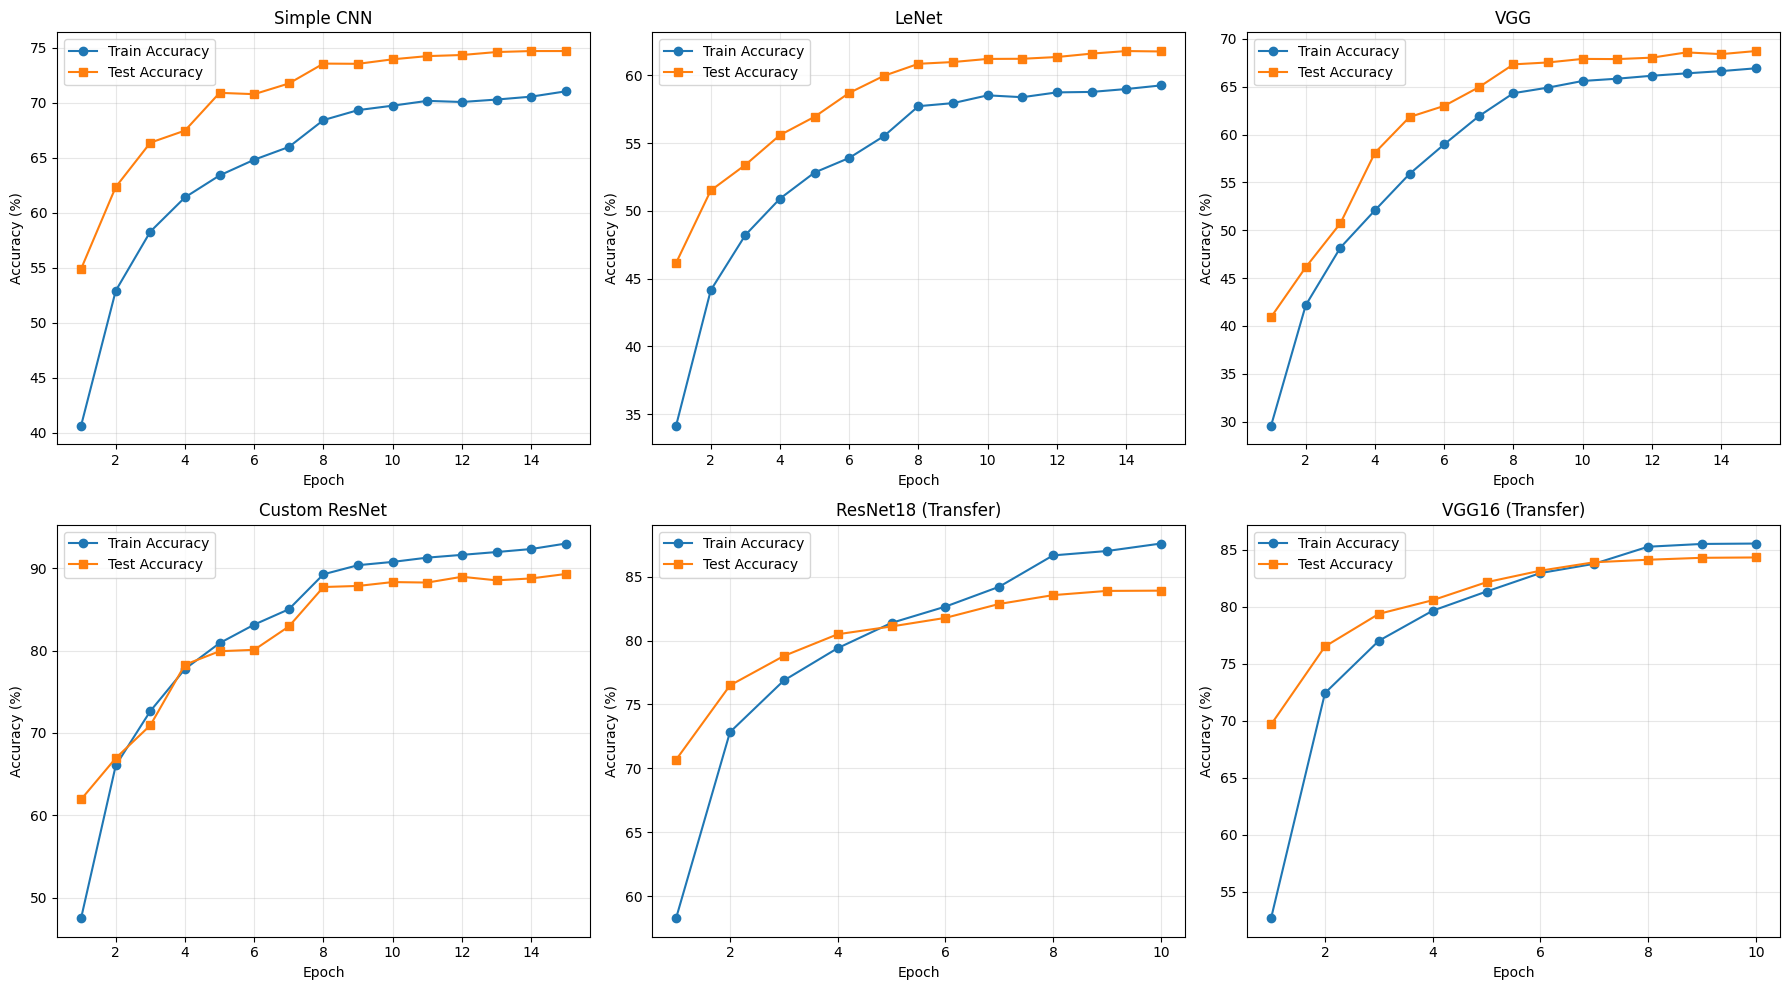

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (model_name, result) in enumerate(results.items()):
    ax = axes[idx]
    epochs = range(1, len(result['train_accs']) + 1)
    ax.plot(epochs, result['train_accs'], label='Train Accuracy', marker='o')
    ax.plot(epochs, result['test_accs'], label='Test Accuracy', marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Accuracy Comparison

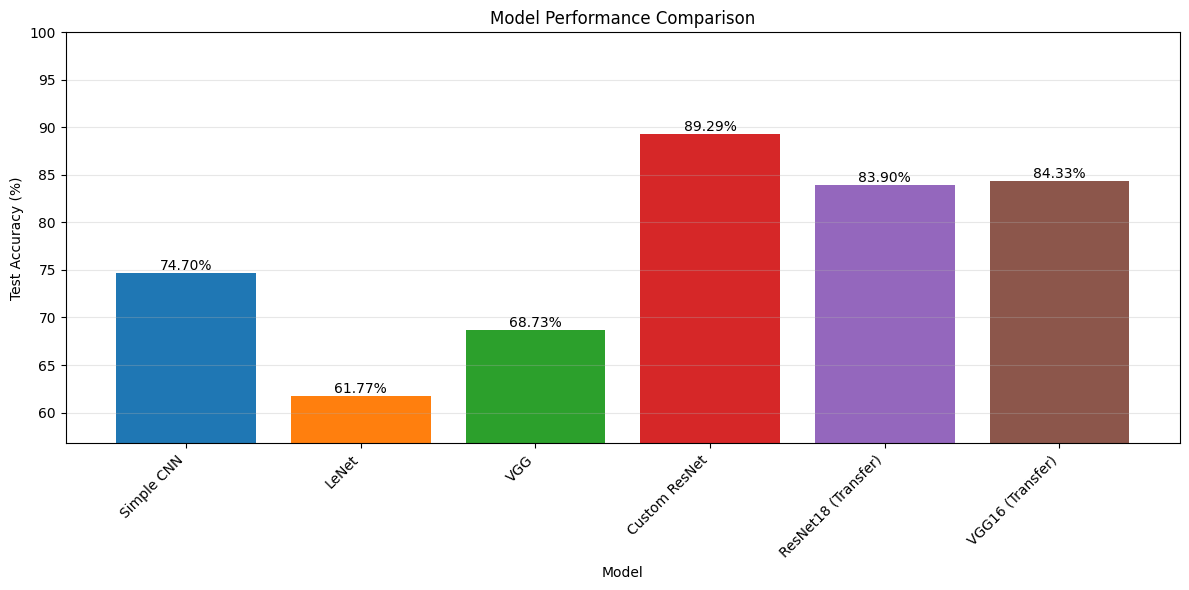

In [15]:
model_names = list(results.keys())
test_accuracies = [results[name]['final_test_acc'] for name in model_names]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, test_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim([min(test_accuracies) - 5, 100])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Confusion Matrix for Best Model

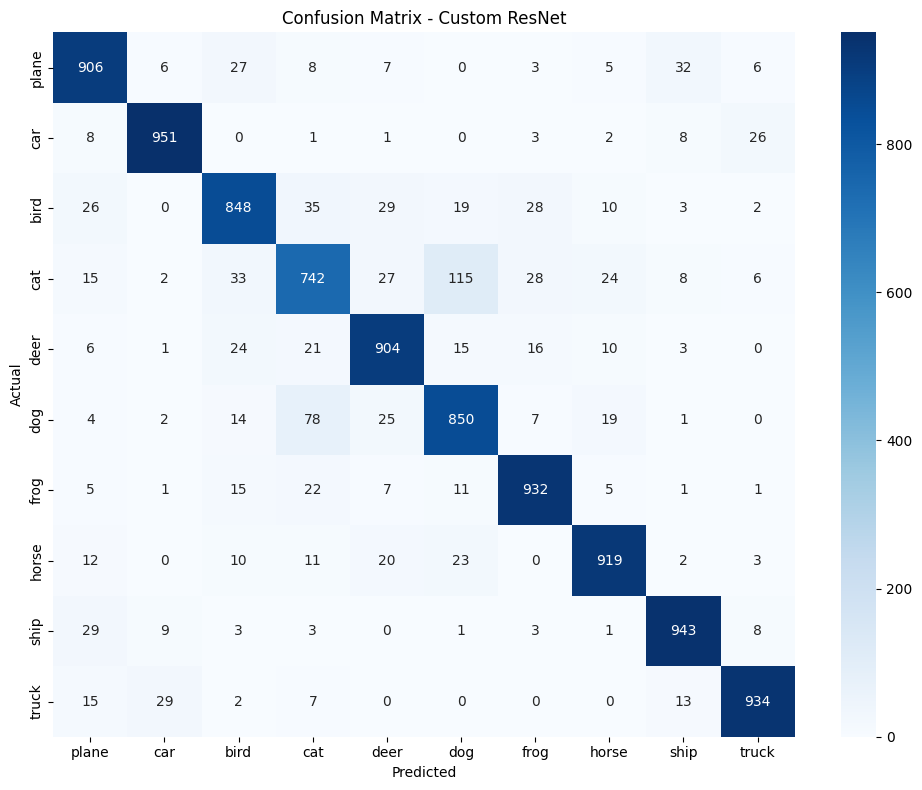

In [16]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Custom ResNet')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(custom_resnet, test_loader, classes)

### Sample Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

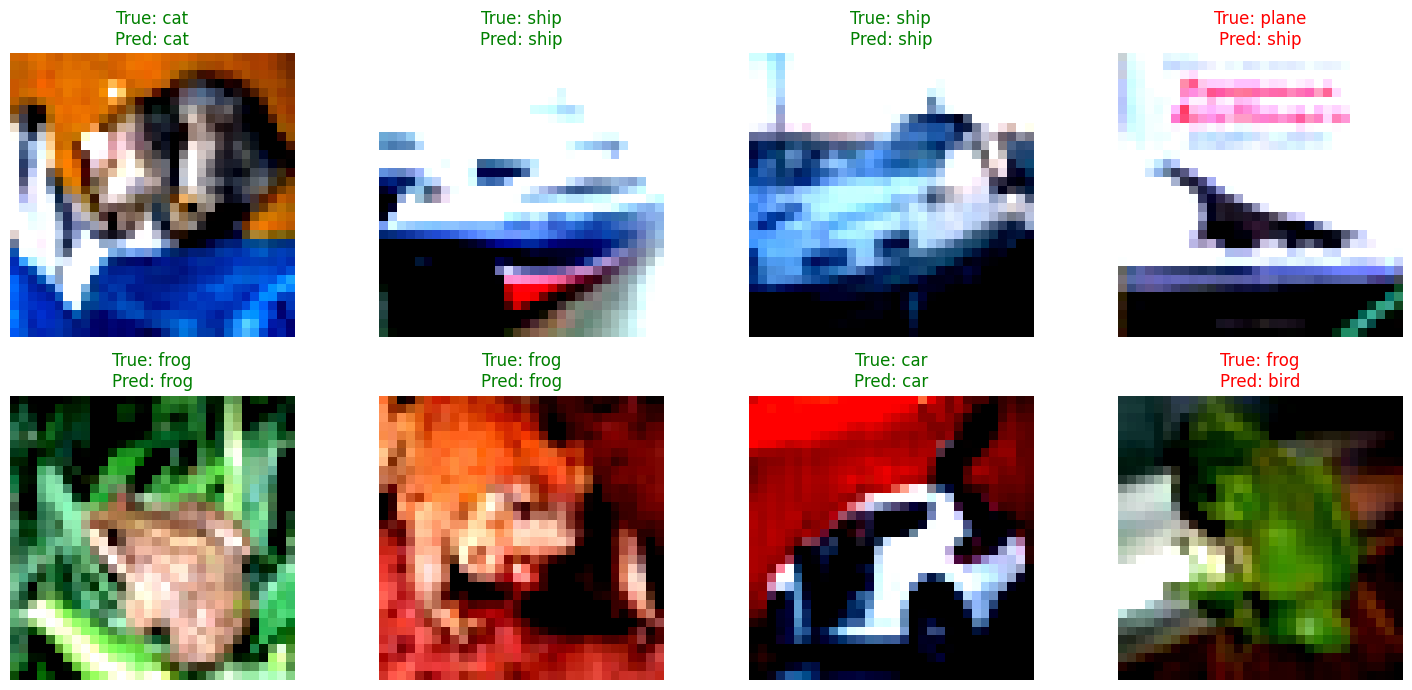

In [17]:
def show_predictions(model, test_loader, num_images=8):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)
    
    images = images.cpu()
    predicted = predicted.cpu()
    labels = labels.cpu()
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 7))
    axes = axes.flatten()
    
    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx] / 2 + 0.5
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'True: {classes[labels[idx]]}\nPred: {classes[predicted[idx]]}',
                    color='green' if predicted[idx] == labels[idx] else 'red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(custom_resnet, test_loader)

## Summary and Conclusions



### Results Summary:
**Custom ResNet** achieved the highest accuracy at **89.29%** (824s training), outperforming all transfer learning models. **ResNet18 Transfer** (83.90%, 502s) offers the best accuracy-to-time ratio. **VGG16 Transfer** reached 84.33% (755s). **Simple CNN** achieved 74.70% in just 132s. **VGG** underperformed at 68.73% (271s), and **LeNet** scored lowest at 61.77% (130s).

### Recommendations:
- **Maximum Accuracy**: Custom ResNet (89.29%) - best for production when training time allows
- **Balanced Performance**: ResNet18 Transfer (83.90% in 502s) - optimal accuracy-to-time ratio  
- **Fast/Lightweight**: Simple CNN (74.70% in 132s) - ideal for resource-constrained environments

### Key Takeaway:
Custom architectures with residual connections can outperform transfer learning on CIFAR-10. Architecture choice depends on constraints: prioritize Custom ResNet for accuracy, ResNet18 Transfer for efficiency, Simple CNN for speed.